In [3]:
import requests
import pandas as pd 
from yahoo_fin import stock_info as si 
from pandas_datareader import DataReader
import numpy as np

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [58]:
tickers = si.tickers_sp500()
recommendations = []

for ticker in tickers:
    lhs_url = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'
    rhs_url = '?formatted=true&crumb=swg7qs5y9UP&lang=en-US&region=US&' \
              'modules=upgradeDowngradeHistory,recommendationTrend,' \
              'financialData,earningsHistory,earningsTrend,industryTrend&' \
              'corsDomain=finance.yahoo.com'
              
    url =  lhs_url + ticker + rhs_url
    r = requests.get(url)
    if not r.ok:
        recommendation = 6
    try:
        result = r.json()['quoteSummary']['result'][0]
        recommendation =result['financialData']['recommendationMean']['fmt']
    except:
        recommendation = 6
    
    recommendations.append(recommendation)


In [61]:
'''How to go from recommendations and result to DF'''
syms = si.tickers_sp500()
df = pd.DataFrame({'Company':syms,'Recommendations':recommendations}) #Not right... Maybe w syms ^^ this thing.
df

,Company,Recommendations
0,A,2.30
1,AAL,3.30
2,AAP,2.30
3,AAPL,2.00
4,ABBV,1.90
...,...,...
500,YUM,2.60
501,ZBH,1.90
502,ZBRA,2.30
503,ZION,2.70


In [62]:


df['Recommendations'] = pd.to_numeric(df['Recommendations'])
df = df[df.Recommendations != 6]
df.sort_values(by=['Recommendations'], ascending = True)

,Company,Recommendations
387,PWR,1.6
72,BSX,1.6
284,LKQ,1.6
150,DXCM,1.6
204,GOOG,1.6
...,...,...
325,MTD,3.3
470,VNO,3.3
61,BEN,3.4
154,ED,3.4


In [63]:
hold_df = df[df.Recommendations == 3]
buy_df = df[df.Recommendations <= 1.5]
sell_df = df[df.Recommendations >= 4.5]

df_list = [hold_df, buy_df, sell_df]
new_df = pd.concat(df_list)
new_df.reset_index(level=0, inplace=True)

In [64]:
'''Begin NEWS Parsing'''

tickers =[] 
  
for index, rows in new_df.iterrows(): 
    tickers.append(rows.Company) 

In [11]:
'''temp -- intermediate step IF NOT PRESENT AFTER CALLING NEXT CELL'''
import nltk
nltk.download('vader_lexicon')
tickers = ['AAPL','AMZN','TSLA']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zoakes/nltk_data...


In [65]:


finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table
    
parsed_news = []

for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
    
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
        
vader = SentimentIntensityAnalyzer()

columns = ['ticker', 'date', 'time', 'headline']

parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline
0,CINF,2020-06-19,11:24AM,Cincinnati Financial (CINF) Plunges 39.2% YTD:...
1,CINF,2020-06-08,12:48PM,3 Low Price-Book Stocks
2,CINF,2020-06-06,08:31AM,Here are the 10 most under and overbought S&P ...
3,CINF,2020-06-05,10:09AM,Hedge Funds Are Done Buying Cincinnati Financi...
4,CINF,2020-06-02,12:33PM,"Pandemic, Protests, and Hurricanes: Can It Get..."


In [67]:
parsed_and_scored_news = parsed_and_scored_news.groupby(['ticker'], as_index = False).agg({'headline': ''.join}, Inplace=True)


In [ ]:
#Intermediate Step

#parsed_and_scored_news.to_pickle('agg_news.pkl')
#pased_and_scores_news = pd.read_pkl('agg_news.pkl')

In [68]:
vader = SentimentIntensityAnalyzer()


scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

scores_df = pd.DataFrame(scores)

parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

In [73]:
scores_df
parsed_and_scored_news

#parsed_and_scored_news.to_pickle('final_news.pkl')
#pased_and_scores_news = pd.read_pkl('final_news.pkl')

,ticker,headline,neg,neu,pos,compound
0,CINF,Cincinnati Financial (CINF) Plunges 39.2% YTD:...,0.025,0.897,0.078,0.9938
1,CLX,Zacks.com featured highlights include: BWX Tec...,0.050,0.824,0.126,0.9974
2,CMA,Friday Morning Market HighlightsWant Income? N...,0.037,0.853,0.111,0.9960
3,COTY,Coty and Kim Kardashian West Announce Strategi...,0.042,0.870,0.088,0.9920
4,CTSH,Accenture Earnings Beat Lifts IT Services Stoc...,0.046,0.846,0.108,0.9922
5,DISCK,Discovery To Report Second-Quarter 2020 Result...,0.033,0.890,0.077,0.9892
6,ITW,3 Top Industrial Stocks to Buy Right NowWhy Is...,0.023,0.850,0.127,0.9985
7,JKHY,SAFE Federal Credit Union Launches Fully Virtu...,0.017,0.863,0.121,0.9984
8,KIM,Hedge Funds Have Never Been This Bullish On Ki...,0.015,0.881,0.104,0.9984
9,KSS,CFCRE Commercial Mortgage Trust 2011-C2 -- Moo...,0.088,0.822,0.090,-0.4860


In [71]:
'''NOW MOVING ONTO OPTIMIZATION'''

'NOW MOVING ONTO OPTIMIZATION'

In [72]:
'''Setting the portfolio ...'''
from pandas_datareader import data as web
import pandas as pd
import numpy as np

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [74]:
tickers = parsed_and_scored_news.ticker.to_list()

In [75]:
assets = tickers

weights = np.array([0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066, 0.066])
weights = np.array([1/len(tickers) for i in tickers]) #Smaller sample
weights

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

In [81]:
'''SUPER HELPFUL !!'''
stockStartDate = '2016-01-01'
#start = dt.datetime(2020,6,1) #Bug -- needs datetime.date object, not strings...
import datetime as dt
stockStartDate = dt.datetime(2016,1,1)
today = datetime.today()
#today = datetime.today().strftime('%Y-%m-%d')

df = pd.DataFrame()

for stock in assets:
    df[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate , end=today)['Adj Close']


In [82]:
df

,CINF,CLX,CMA,COTY,CTSH,DISCK,ITW,JKHY,KIM,KSS,L,RHI,UA,UAA,WRB
Date,,,,,,,,,,,,,,,
2016-01-04,50.590199,111.527649,36.419037,21.702024,55.877968,25.160000,81.805313,72.599312,19.730579,39.280003,36.859318,42.027195,79.660004,39.830002,32.405499
2016-01-05,50.889130,113.138954,36.023472,21.693323,55.877968,25.270000,80.610481,73.661812,20.351234,39.462341,36.966637,42.163815,80.150002,40.075001,32.685181
2016-01-06,50.194550,113.085556,35.610317,21.023563,54.916706,25.100000,78.625099,73.718727,20.167336,39.676376,36.147110,41.043465,79.870003,39.935001,32.271751
2016-01-07,49.077942,111.848152,34.889492,20.414688,54.445686,24.320000,76.118660,72.931351,19.661623,40.318485,35.278793,40.897728,78.000000,39.000000,31.724564
2016-01-08,48.822964,112.328857,34.282940,20.379896,53.599781,25.000000,75.480812,72.523438,19.324472,37.956146,35.025131,39.886669,75.000000,37.500000,31.621208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,63.790001,213.380005,39.830002,4.650000,55.200001,20.059999,171.469711,182.119995,13.050000,22.000000,34.340000,51.919998,8.930000,9.860000,57.639999
2020-06-24,62.009998,212.029999,37.450001,4.330000,53.799999,19.680000,167.952286,179.690002,12.810000,20.639999,33.169998,49.470001,8.580000,9.470000,55.740002
2020-06-25,63.740002,214.919998,38.680000,4.360000,55.590000,19.270000,169.869980,180.250000,12.750000,19.910000,33.840000,50.340000,8.670000,9.600000,56.980000


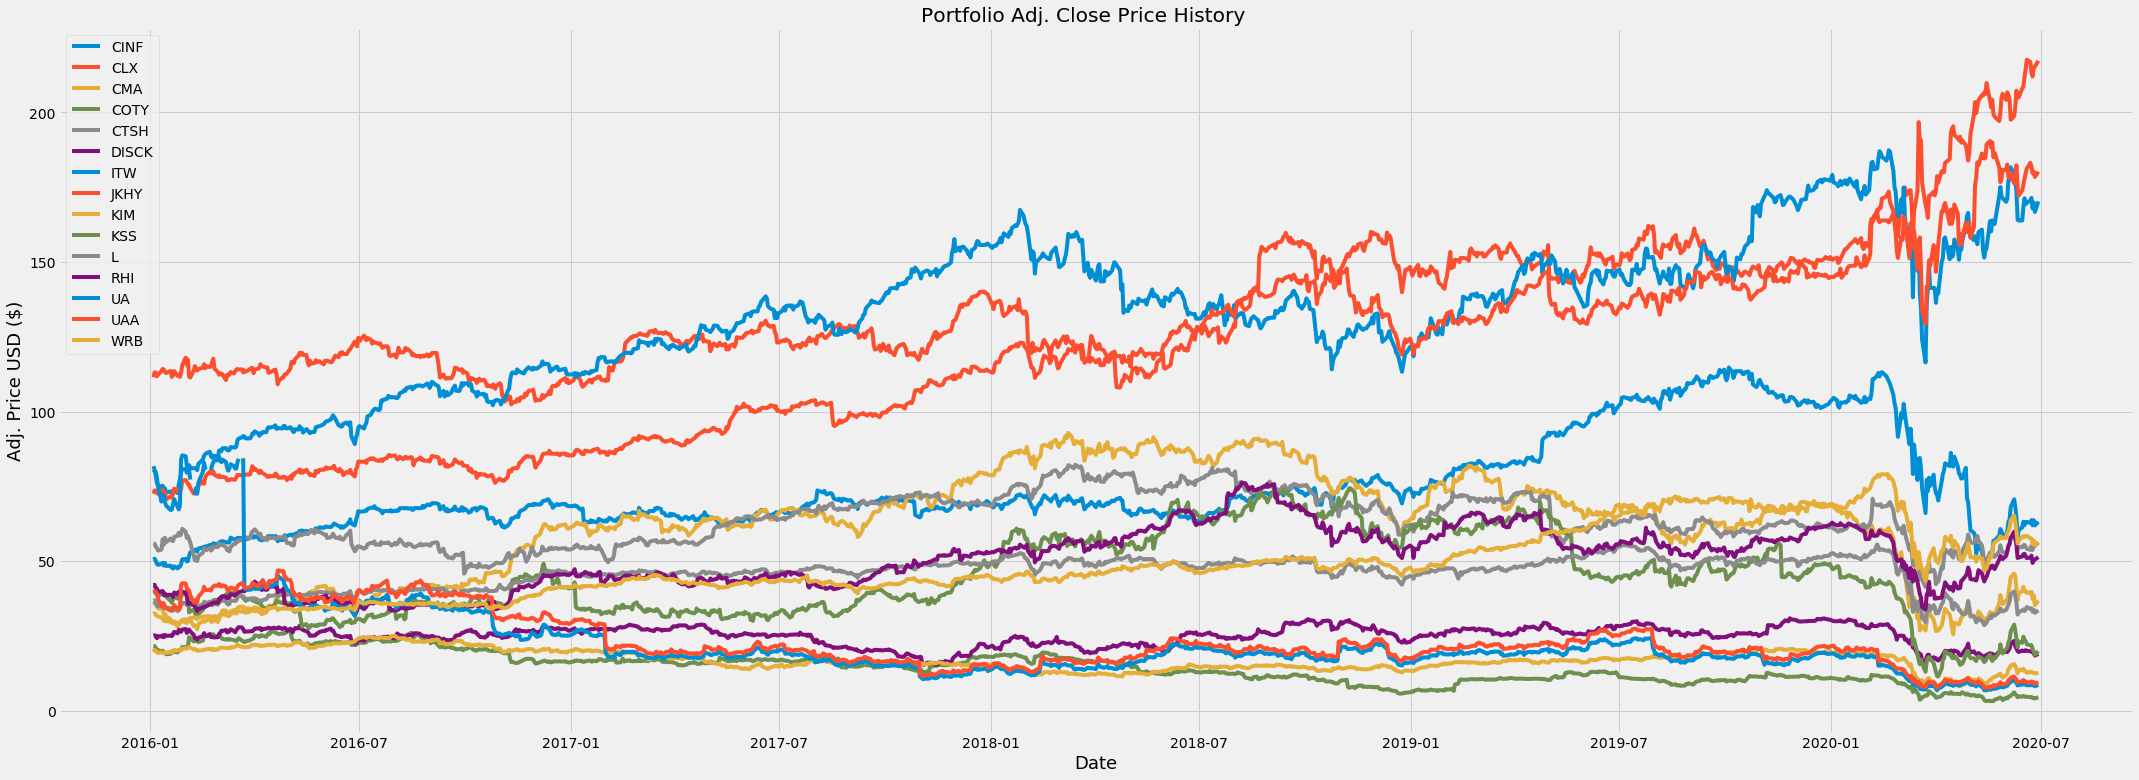

In [83]:
title = 'Portfolio Adj. Close Price History    '
my_stocks = df
plt.figure(figsize=(33.1,12.1)) 

for c in my_stocks.columns.values:
    plt.plot( my_stocks[c],  label=c)

plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price USD ($)',fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()


In [84]:
returns = df.pct_change()
returns

,CINF,CLX,CMA,COTY,CTSH,DISCK,ITW,JKHY,KIM,KSS,L,RHI,UA,UAA,WRB
Date,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.005909,0.014448,-0.010861,-0.000401,0.000000,0.004372,-0.014606,0.014635,0.031457,0.004642,0.002912,0.003251,0.006151,0.006151,0.008631
2016-01-06,-0.013649,-0.000472,-0.011469,-0.030874,-0.017203,-0.006727,-0.024629,0.000773,-0.009036,0.005424,-0.022169,-0.026571,-0.003493,-0.003493,-0.012649
2016-01-07,-0.022246,-0.010942,-0.020242,-0.028962,-0.008577,-0.031076,-0.031878,-0.010681,-0.025076,0.016184,-0.024022,-0.003551,-0.023413,-0.023413,-0.016956
2016-01-08,-0.005195,0.004298,-0.017385,-0.001704,-0.015537,0.027961,-0.008380,-0.005593,-0.017148,-0.058592,-0.007190,-0.024722,-0.038462,-0.038462,-0.003258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,0.015764,-0.016229,0.006825,0.006494,0.025070,0.009054,0.005126,-0.005732,-0.000766,0.002735,0.008221,0.013073,0.040793,0.036803,-0.001213
2020-06-24,-0.027904,-0.006327,-0.059754,-0.068817,-0.025362,-0.018943,-0.020513,-0.013343,-0.018391,-0.061818,-0.034071,-0.047188,-0.039194,-0.039554,-0.032963
2020-06-25,0.027899,0.013630,0.032844,0.006928,0.033271,-0.020833,0.011418,0.003116,-0.004684,-0.035368,0.020199,0.017586,0.010490,0.013728,0.022246


In [85]:
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,CINF,CLX,CMA,COTY,CTSH,DISCK,ITW,JKHY,KIM,KSS,L,RHI,UA,UAA,WRB
CINF,0.088749,0.017553,0.066251,0.048644,0.048986,0.039321,0.047321,0.033541,0.053574,0.068956,0.063527,0.048655,0.057159,0.060217,0.060286
CLX,0.017553,0.047168,0.002579,0.012457,0.010947,0.004418,0.015318,0.014496,0.012881,0.003789,0.015334,0.006301,0.013344,0.012932,0.015259
CMA,0.066251,0.002579,0.157483,0.088314,0.065093,0.067568,0.065661,0.030313,0.076282,0.107586,0.080829,0.075742,0.094586,0.095163,0.061912
COTY,0.048644,0.012457,0.088314,0.344119,0.050491,0.055043,0.050009,0.020626,0.086268,0.093221,0.059564,0.055430,0.098749,0.101623,0.045033
CTSH,0.048986,0.010947,0.065093,0.050491,0.095290,0.043771,0.046474,0.035925,0.050131,0.058703,0.052093,0.046333,0.058051,0.060875,0.045234
DISCK,0.039321,0.004418,0.067568,0.055043,0.043771,0.125677,0.041047,0.021189,0.050872,0.079556,0.053259,0.049378,0.073074,0.068553,0.036905
ITW,0.047321,0.015318,0.065661,0.050009,0.046474,0.041047,0.070937,0.030145,0.041518,0.063088,0.053774,0.052092,0.058975,0.060732,0.041055
JKHY,0.033541,0.014496,0.030313,0.020626,0.035925,0.021189,0.030145,0.048817,0.022023,0.028401,0.034286,0.031480,0.032129,0.034154,0.029750
KIM,0.053574,0.012881,0.076282,0.086268,0.050131,0.050872,0.041518,0.022023,0.134451,0.103844,0.058423,0.049043,0.080173,0.082419,0.052265
KSS,0.068956,0.003789,0.107586,0.093221,0.058703,0.079556,0.063088,0.028401,0.103844,0.293502,0.075854,0.080911,0.122892,0.126523,0.058225


In [86]:
'''calculate variance... HIGH'''
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.06130997622387373

In [87]:
port_volatility = np.sqrt(port_variance) #Sigma 
portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights) * 252

print(f'PF Vol: {port_volatility}')
print(f'PF Ann Return: {portfolioSimpleAnnualReturn}')

PF Vol: 0.24760851403753006
PF Ann Return: 0.027324895863018634


In [88]:
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

Expected annual return : 3.0%
Annual volatility/standard deviation/risk : 25.0%
Annual variance : 6.0%


In [89]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [90]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

In [91]:
'''optimizing the Efficient Frontier using CAPM'''

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() 
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) 
ef.portfolio_performance(verbose=True)

OrderedDict([('CINF', 0.0), ('CLX', 0.33843), ('CMA', 0.0), ('COTY', 0.0), ('CTSH', 0.0), ('DISCK', 0.0), ('ITW', 0.12284), ('JKHY', 0.53873), ('KIM', 0.0), ('KSS', 0.0), ('L', 0.0), ('RHI', 0.0), ('UA', 0.0), ('UAA', 0.0), ('WRB', 0.0)])
Expected annual return: 20.5%
Annual volatility: 17.7%
Sharpe Ratio: 1.05


(0.20529674773794443, 0.1766076747580877, 1.0491998606049187)

In [92]:
'''Allocation -- based on 15k budget'''

latest_prices = get_latest_prices(df)
weights = cleaned_weights 
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)

Discrete allocation: {'CLX': 23.0, 'ITW': 11.0, 'JKHY': 45.0, 'UA': 1.0, 'UAA': 1.0}


In [93]:
for k,v in allocation.items():
    print(f'{k} : {v} shares')
    
syms = list(allocation.keys())
shares = list(allocation.values())
print(syms)
share_df = pd.DataFrame({'Symbol':syms,'Shares':shares}).set_index('Symbol')
#init_shares = df.from_dict(allocation)
share_df

CLX : 23.0 shares
ITW : 11.0 shares
JKHY : 45.0 shares
UA : 1.0 shares
UAA : 1.0 shares
['CLX', 'ITW', 'JKHY', 'UA', 'UAA']


,Shares
Symbol,
CLX,23.0
ITW,11.0
JKHY,45.0
UA,1.0
UAA,1.0
